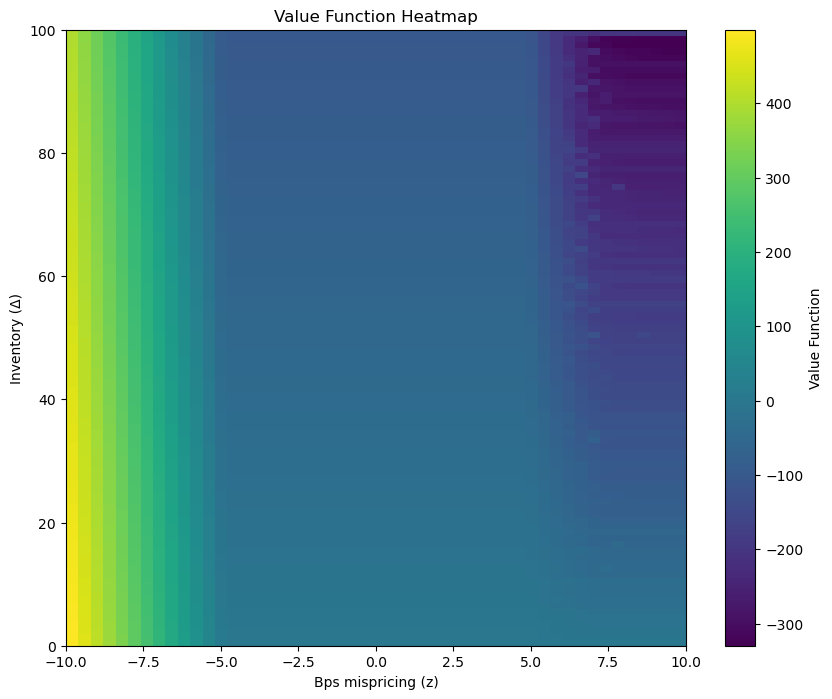

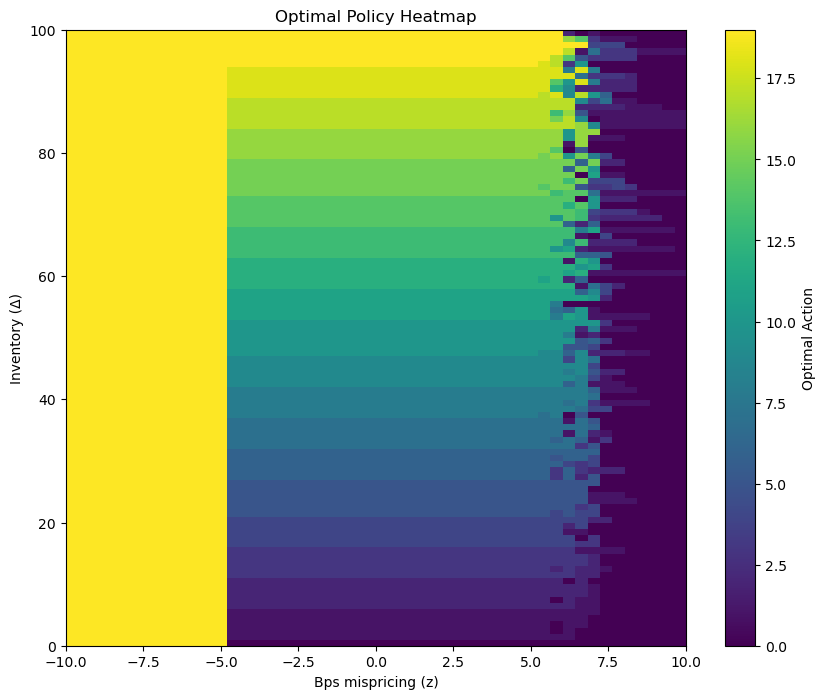

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox

class AMM_MDP:
    def __init__(self, T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho):
        self.T = T  # time steps
        self.Delta_bar = Delta_bar  # initial inventory
        self.z0 = z0  # initial mispricing
        self.R0 = R0  # initial reserve of asset 0
        self.R1 = R1  # initial reserve of asset 1
        self.p0 = R1/R0  # initial price
        self.k = R1*R0  # xy=k
        self.g = g  # gas cost
        self.sigma = sigma  # volatility of mispricing
        self.mu = mu  # mean brownian motion
        self.gamma = gamma  # fee
        self.lambda_ = lambda_  # Poisson block time
        self.phi = phi  # running inventory cost
        self.dt = 1 / T
        self.rho = rho # convexity cost of underlying AMM

        # Discretize the state and action spaces
        self.Delta_space = np.linspace(0, Delta_bar, 100)
        self.z_space = np.linspace(-2 * gamma, 2 * gamma, 50)
        self.actions = np.linspace(0, Delta_bar, 20)

    def swap_jump(self, z, a):
        z_star = self.jump(z)
        return z_star + (1-self.rho)*self.R1/(self.R0 + 2*a)
        
    def execution_price_improvement(self, z, a):
        z_star = self.jump(z)
        return (z_star - self.rho * self.R1/(self.R0 + a)) * a

    def jump(self, z):
        if z > self.gamma:
            return self.gamma - z
        elif z < -self.gamma:
            return -self.gamma - z
        else:
            return 0
  
    def transition(self, Delta, z, a):
        Delta_next = Delta - a
        z = z + self.mu * self.dt + self.sigma * np.sqrt(self.dt) * np.random.randn()
        J = self.jump(z)
        z_star = z + J
        z_next = z_star + self.swap_jump(z_star, a)
        return Delta_next, z_next

    def reward(self, Delta, z, a):
        reward = self.execution_price_improvement(z, a)
        reward -= self.g * (a > 0) + self.phi * Delta
        return reward

    def terminal_reward(self, Delta, z):
        z_star = self.jump(z)
        return (-z_star + self.rho * self.R1/(self.R0 + Delta)) * Delta

    def build_mdp_matrices(self):
        n_states = len(self.Delta_space) * len(self.z_space)
        n_actions = len(self.actions)
        P = np.zeros((n_actions, n_states, n_states))
        R = np.zeros((n_states, n_actions))

        for i, Delta in enumerate(self.Delta_space):
            for j, z in enumerate(self.z_space):
                state_index = i * len(self.z_space) + j
                for k, a in enumerate(self.actions):
                    Delta_next, z_next = self.transition(Delta, z, a)
                    reward = self.reward(Delta, z, a)

                    Delta_index = np.searchsorted(self.Delta_space, Delta_next)
                    z_index = np.searchsorted(self.z_space, z_next)
                    Delta_index = min(Delta_index, len(self.Delta_space) - 1)
                    z_index = min(z_index, len(self.z_space) - 1)
                    next_state_index = Delta_index * len(self.z_space) + z_index

                    P[k, state_index, next_state_index] += 1
                    R[state_index, k] = reward

                    # Add terminal reward
                    if i == len(self.Delta_space) - 1:  # If it's the last time step
                        R[state_index, k] += self.terminal_reward(Delta_next, z_next)

        # Normalize transition probabilities
        for k in range(n_actions):
            P[k] /= P[k].sum(axis=1)[:, None]

        return P, R

    def simulate(self, policy, num_simulations=100):
        inventory_paths = []
        for _ in range(num_simulations):
            Delta = self.Delta_bar
            z = self.z0
            inventory = [Delta]
            for t in range(self.T):
                state_index = np.searchsorted(self.Delta_space, Delta) * len(self.z_space) + np.searchsorted(self.z_space, z)
                action_index = policy[state_index]
                action = self.actions[action_index]
                Delta, z = self.transition(Delta, z, action)
                inventory.append(Delta)
            inventory_paths.append(inventory)
        return np.mean(inventory_paths, axis=0)

# Parameters
T = 10
Delta_bar = 100
z0 = 0
R0 = 10000
R1 = 10000
gamma = 5  # 0.3% fee
g = 0.1
sigma = 4
mu = 0
lambda_ = 1
phi = 1  # Running inventory cost
rho = 0.01 #convexity cost

# Initialize MDP
mdp = AMM_MDP(T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho)

# Build transition and reward matrices
P, R = mdp.build_mdp_matrices()

# Solve MDP using value iteration
vi = mdptoolbox.mdp.ValueIteration(P, R, 1)
vi.run()

# Visualize the value function and optimal policy for the last phi value
value_function_reshaped = np.array(vi.V).reshape((len(mdp.Delta_space), len(mdp.z_space)))
optimal_policy_reshaped = np.array(vi.policy).reshape((len(mdp.Delta_space), len(mdp.z_space)))

# Value Function Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(value_function_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)])
plt.colorbar(label='Value Function')
plt.xlabel('Bps mispricing (z)')
plt.ylabel('Inventory (Δ)')
plt.title('Value Function Heatmap')
plt.show()

# Optimal Policy Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(optimal_policy_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)])
plt.colorbar(label='Optimal Action')
plt.xlabel('Bps mispricing (z)')
plt.ylabel('Inventory (Δ)')
plt.title('Optimal Policy Heatmap')
plt.show()

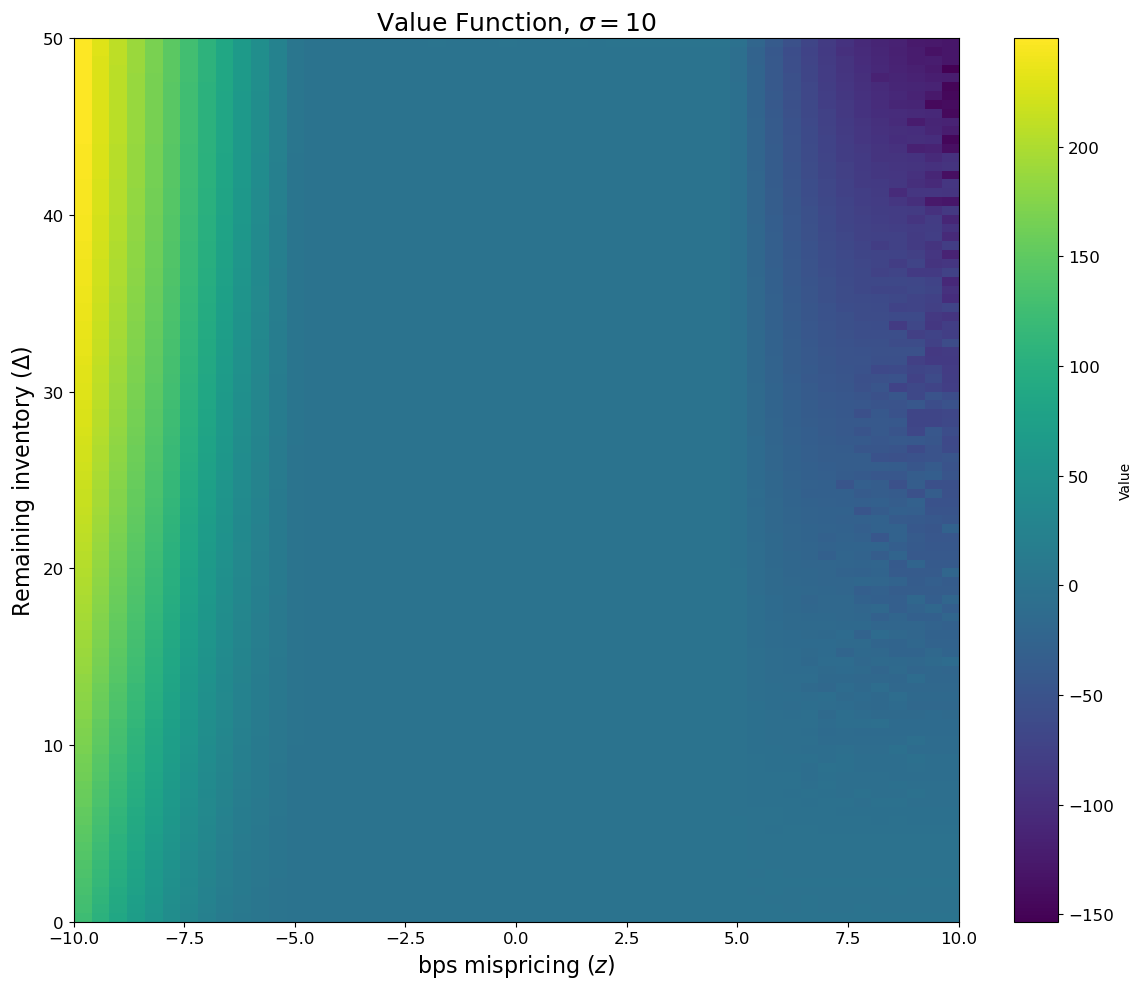

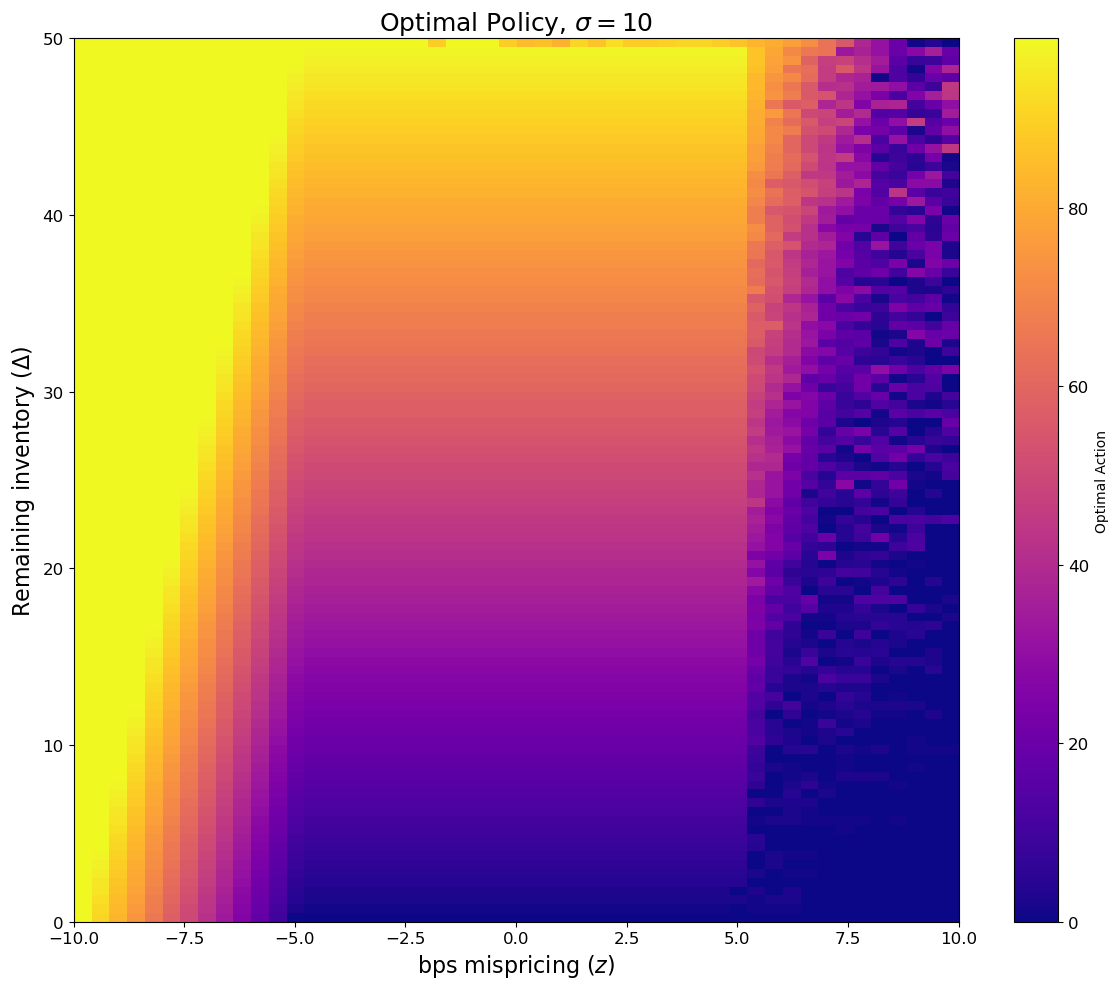

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox

class AMM_MDP:
    def __init__(self, T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho):
        self.T = T  # time steps
        self.Delta_bar = Delta_bar  # initial inventory
        self.z0 = z0  # initial mispricing
        self.R0 = R0  # initial reserve of asset 0
        self.R1 = R1  # initial reserve of asset 1
        self.p0 = R1/R0  # initial price
        self.k = R1*R0  # xy=k
        self.g = g  # gas cost
        self.sigma = sigma  # volatility of mispricing
        self.mu = mu  # mean brownian motion
        self.gamma = gamma  # fee
        self.lambda_ = lambda_  # Poisson block time
        self.phi = phi  # running inventory cost
        self.dt = 1 / T
        self.rho = rho # convexity cost of underlying AMM

        # Discretize the state and action spaces
        self.Delta_space = np.linspace(0, Delta_bar, 100)
        self.z_space = np.linspace(-2 * gamma, 2 * gamma, 50)
        self.actions = np.linspace(0, Delta_bar, 100)

    def swap_jump(self, z, a):
        z_star = self.jump(z)
        return z_star + (1-self.rho)*self.R1/(self.R0 + 2*a)
        
    def execution_price_improvement(self, z, a):
        z_star = self.jump(z)
        return (z_star - self.rho * self.R1/(self.R0 + a)) * a

    def jump(self, z):
        if z > self.gamma:
            return self.gamma - z
        elif z < -self.gamma:
            return -self.gamma - z
        else:
            return 0
  
    def transition(self, Delta, z, a):
        Delta_next = Delta - a
        z = z + self.mu * self.dt + self.sigma * np.sqrt(self.dt) * np.random.randn()
        J = self.jump(z)
        z_star = z + J
        z_next = z_star + self.swap_jump(z_star, a)
        return Delta_next, z_next

    def reward(self, Delta, z, a):
        reward = self.execution_price_improvement(z, a)
        reward -= self.g * (a > 0) + self.phi * Delta**2
        return reward

    def terminal_reward(self, Delta, z):
        z_star = self.jump(z)
        return (-z_star + self.rho * self.R1/(self.R0 + Delta)) * Delta

    def build_mdp_matrices(self):
        n_states = len(self.Delta_space) * len(self.z_space)
        n_actions = len(self.actions)
        P = np.zeros((n_actions, n_states, n_states))
        R = np.zeros((n_states, n_actions))

        for i, Delta in enumerate(self.Delta_space):
            for j, z in enumerate(self.z_space):
                state_index = i * len(self.z_space) + j
                for k, a in enumerate(self.actions):
                    Delta_next, z_next = self.transition(Delta, z, a)
                    reward = self.reward(Delta_next, z, a)

                    Delta_index = np.searchsorted(self.Delta_space, Delta_next)
                    z_index = np.searchsorted(self.z_space, z_next)
                    Delta_index = min(Delta_index, len(self.Delta_space) - 1)
                    z_index = min(z_index, len(self.z_space) - 1)
                    next_state_index = Delta_index * len(self.z_space) + z_index

                    P[k, state_index, next_state_index] += 1
                    R[state_index, k] = reward

                    # Add terminal reward
                    if i == len(self.Delta_space) - 1:  # If it's the last time step
                        R[state_index, k] += self.terminal_reward(Delta_next, z_next)

        # Normalize transition probabilities
        for k in range(n_actions):
            P[k] /= P[k].sum(axis=1)[:, None]

        return P, R

    def simulate(self, policy, num_simulations=100):
        inventory_paths = []
        for _ in range(num_simulations):
            Delta = self.Delta_bar
            z = self.z0
            inventory = [Delta]
            for t in range(self.T):
                state_index = np.searchsorted(self.Delta_space, Delta) * len(self.z_space) + np.searchsorted(self.z_space, z)
                action_index = policy[state_index]
                action = self.actions[action_index]
                Delta, z = self.transition(Delta, z, action)
                inventory.append(Delta)
            inventory_paths.append(inventory)
        return np.mean(inventory_paths, axis=0)

# Parameters
T = 10
Delta_bar = 50
z0 = 0
R0 = 10000
R1 = 10000
gamma = 5  # 0.3% fee
g = 0.1
sigma = 10
mu = 0
lambda_ = 1
phi = .05  # Running inventory cost
rho = 0.01 #convexity cost

# Initialize MDP
mdp = AMM_MDP(T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho)

# Build transition and reward matrices
P, R = mdp.build_mdp_matrices()

# Solve MDP using value iteration
vi = mdptoolbox.mdp.ValueIteration(P, R, 1)
vi.run()

# Visualize the value function and optimal policy for the last phi value
value_function_reshaped = np.array(vi.V).reshape((len(mdp.Delta_space), len(mdp.z_space)))
optimal_policy_reshaped = np.array(vi.policy).reshape((len(mdp.Delta_space), len(mdp.z_space)))

# Customize colormap
cmap_value = plt.get_cmap('viridis')  # Use a perceptually uniform colormap for value function
cmap_policy = plt.get_cmap('plasma')  # Use a different colormap for optimal policy

# Value Function Heatmap
plt.figure(figsize=(12, 10))
plt.imshow(value_function_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)],
           cmap=cmap_value)
cbar = plt.colorbar(label='Value')
cbar.ax.tick_params(labelsize=12)  # Increase colorbar tick label size

plt.xlabel('bps mispricing ($z$)', fontsize=16)
plt.ylabel('Remaining inventory ($\\Delta$)', fontsize=16)
plt.title('Value Function, $\sigma = 10$', fontsize=18)
plt.xticks(fontsize=12)  # Increase x-axis tick label size
plt.yticks(fontsize=12)  # Increase y-axis tick label size
plt.grid(False)  # Remove grid lines if present
plt.tight_layout()  # Adjust layout to fit elements
plt.savefig('figures/value_function_sigma_10.png', dpi=300, bbox_inches='tight')
plt.show()

# Optimal Policy Heatmap
plt.figure(figsize=(12, 10))
plt.imshow(optimal_policy_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)],
           cmap=cmap_policy)
cbar = plt.colorbar(label='Optimal Action')
cbar.ax.tick_params(labelsize=12)  # Increase colorbar tick label size

plt.xlabel('bps mispricing ($z$)', fontsize=16)
plt.ylabel('Remaining inventory ($\\Delta$)', fontsize=16)
plt.title('Optimal Policy, $\sigma = 10$', fontsize=18)
plt.xticks(fontsize=12)  # Increase x-axis tick label size
plt.yticks(fontsize=12)  # Increase y-axis tick label size
plt.grid(False)  # Remove grid lines if present
plt.tight_layout()  # Adjust layout to fit elements
plt.savefig('figures/optimal_policy_sigma_10.png', dpi=300, bbox_inches='tight')
plt.show()

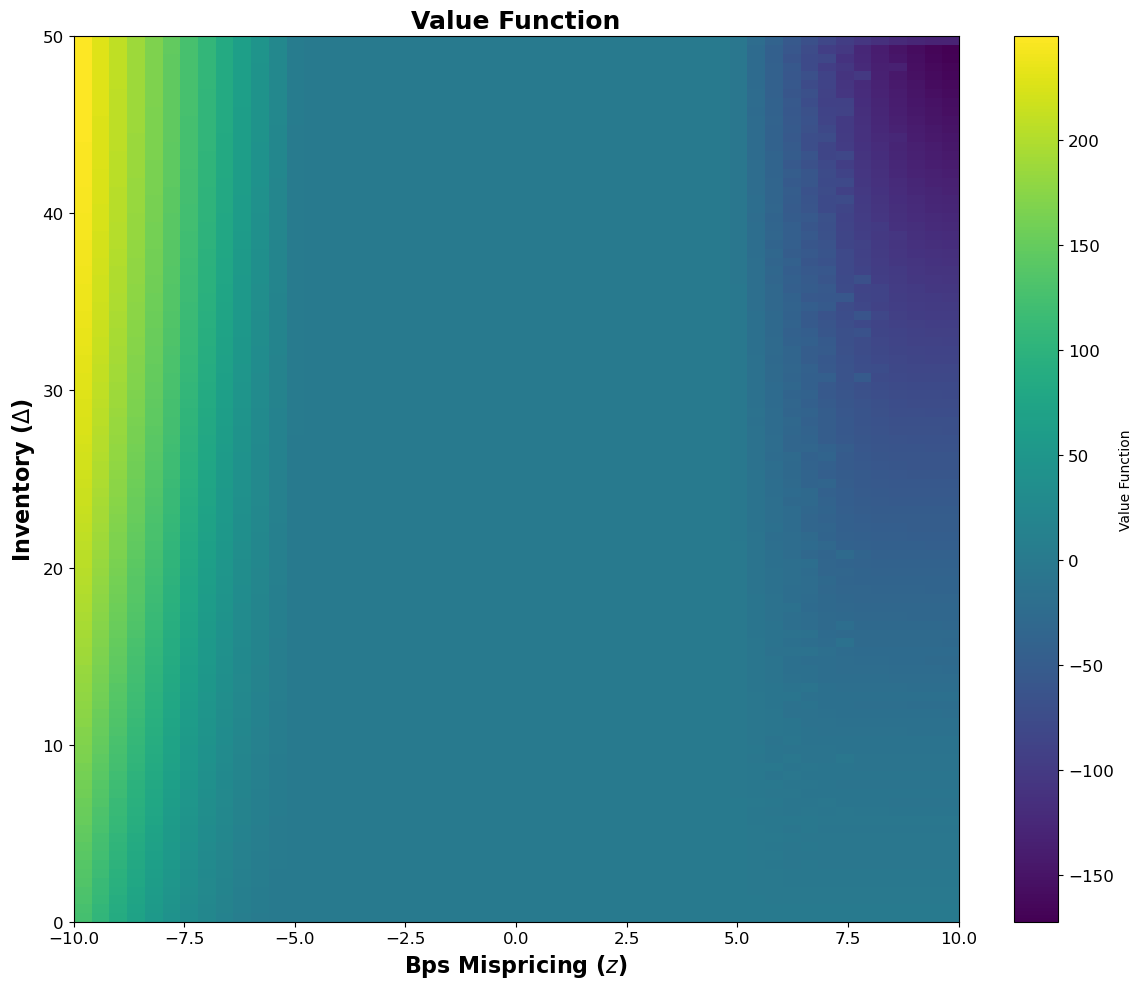

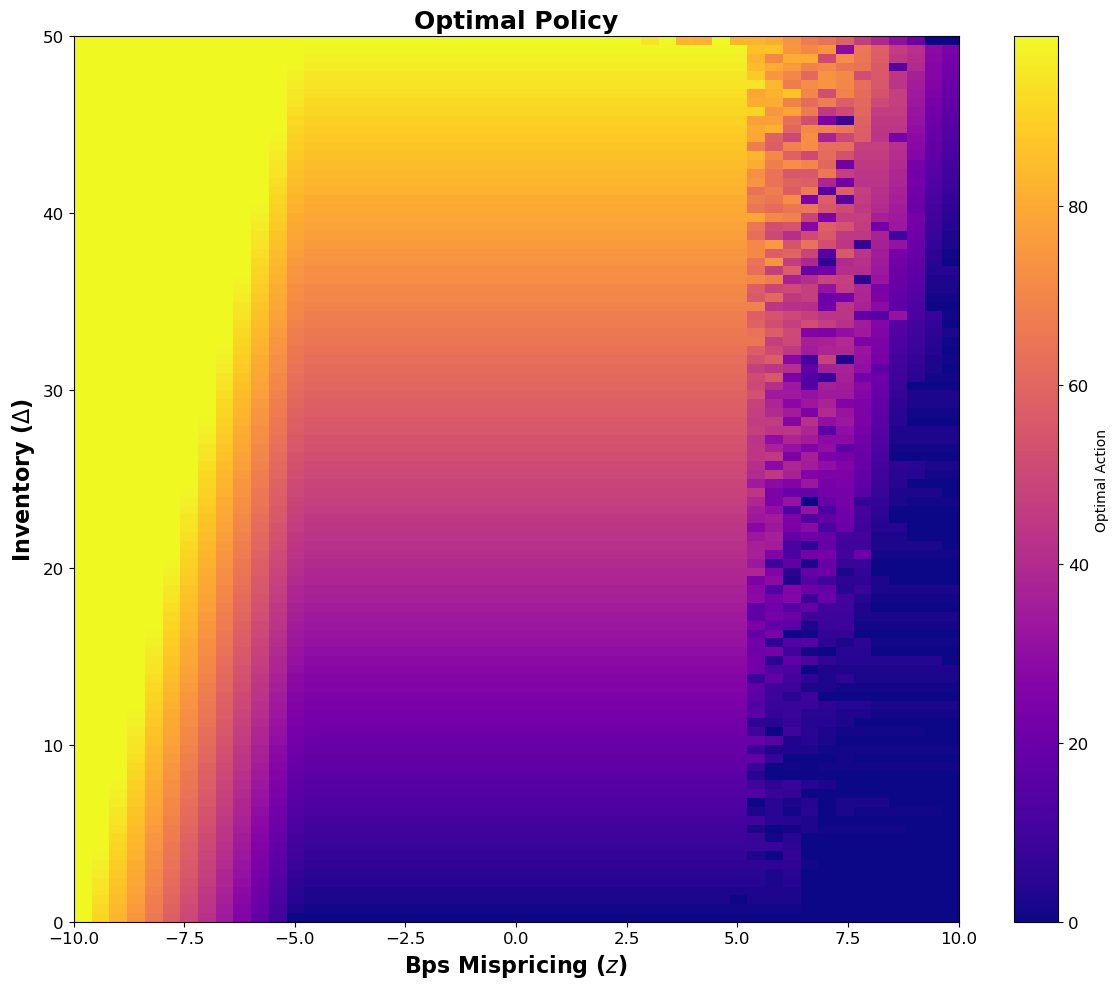

In [13]:
# Customize colormap
cmap_value = plt.get_cmap('viridis')  # Use a perceptually uniform colormap for value function
cmap_policy = plt.get_cmap('plasma')  # Use a different colormap for optimal policy

# Value Function Heatmap
plt.figure(figsize=(12, 10))
plt.imshow(value_function_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)],
           cmap=cmap_value)
cbar = plt.colorbar(label='Value Function')
cbar.ax.tick_params(labelsize=12)  # Increase colorbar tick label size

plt.xlabel('Bps Mispricing ($z$)', fontsize=16, fontweight='bold')
plt.ylabel('Inventory ($\\Delta$)', fontsize=16, fontweight='bold')
plt.title('Value Function', fontsize=18, fontweight='bold')
plt.xticks(fontsize=12)  # Increase x-axis tick label size
plt.yticks(fontsize=12)  # Increase y-axis tick label size
plt.grid(False)  # Remove grid lines if present
plt.tight_layout()  # Adjust layout to fit elements
plt.savefig('figures/value_function.png', dpi=300, bbox_inches='tight')
plt.show()

# Optimal Policy Heatmap
plt.figure(figsize=(12, 10))
plt.imshow(optimal_policy_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)],
           cmap=cmap_policy)
cbar = plt.colorbar(label='Optimal Action')
cbar.ax.tick_params(labelsize=12)  # Increase colorbar tick label size

plt.xlabel('Bps Mispricing ($z$)', fontsize=16, fontweight='bold')
plt.ylabel('Inventory ($\\Delta$)', fontsize=16, fontweight='bold')
plt.title('Optimal Policy', fontsize=18, fontweight='bold')
plt.xticks(fontsize=12)  # Increase x-axis tick label size
plt.yticks(fontsize=12)  # Increase y-axis tick label size
plt.grid(False)  # Remove grid lines if present
plt.tight_layout()  # Adjust layout to fit elements
plt.savefig('figures/optimal_policy.png', dpi=300, bbox_inches='tight')
plt.show()

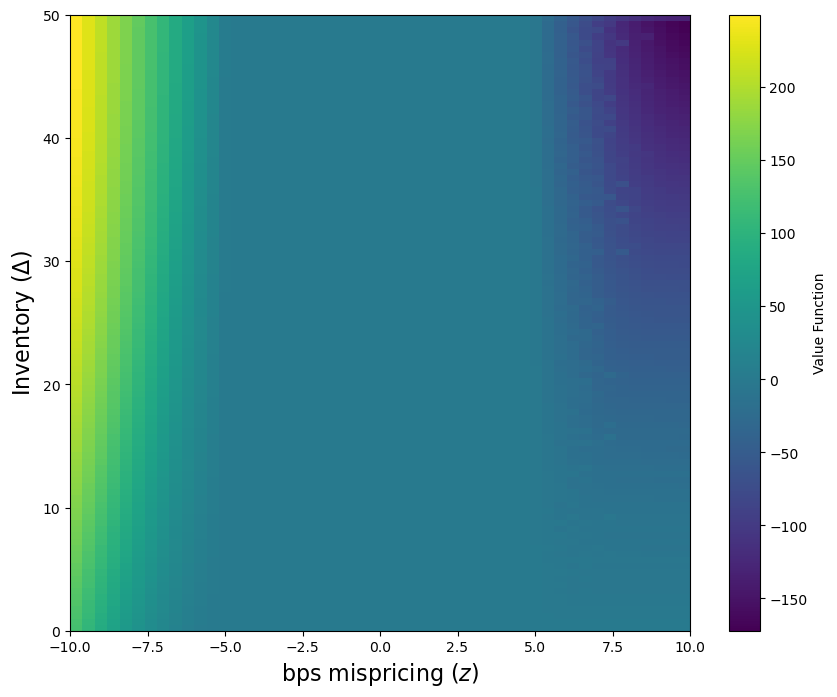

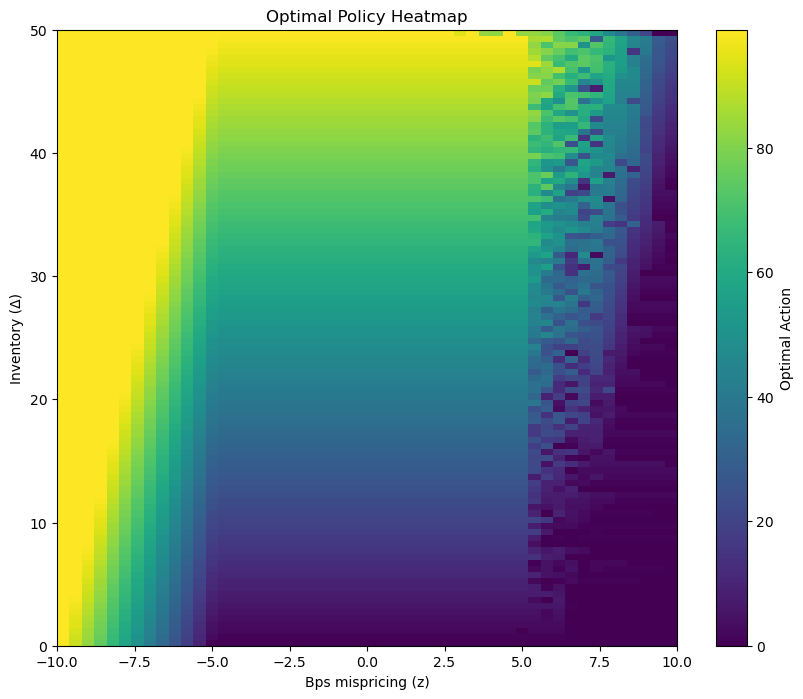

In [7]:
# Value Function Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(value_function_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)])
plt.colorbar(label='Value Function')
plt.xlabel('bps mispricing ($z$)', fontsize = 16)
plt.ylabel('Inventory ($\Delta$)', fontsize = 16)
plt.show()

# Optimal Policy Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(optimal_policy_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)])
plt.colorbar(label='Optimal Action')
plt.xlabel('Bps mispricing (z)')
plt.ylabel('Inventory (Δ)')
plt.title('Optimal Policy Heatmap')
plt.show()

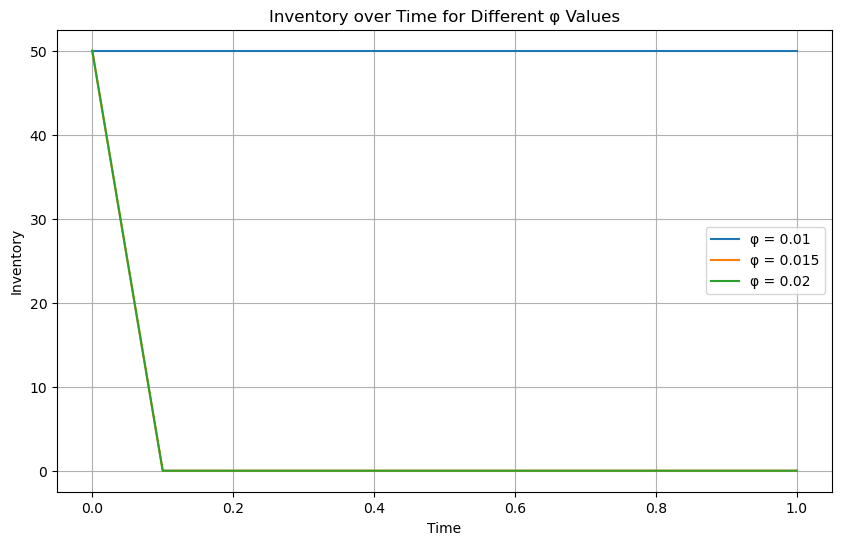

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox

class AMM_MDP:
    def __init__(self, T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho):
        self.T = T  # time steps
        self.Delta_bar = Delta_bar  # initial inventory
        self.z0 = z0  # initial mispricing
        self.R0 = R0  # initial reserve of asset 0
        self.R1 = R1  # initial reserve of asset 1
        self.p0 = R1/R0  # initial price
        self.k = R1*R0  # xy=k
        self.g = g  # gas cost
        self.sigma = sigma  # volatility of mispricing
        self.mu = mu  # mean brownian motion
        self.gamma = gamma  # fee
        self.lambda_ = lambda_  # Poisson block time
        self.phi = phi  # running inventory cost
        self.dt = 1 / T
        self.rho = rho # convexity cost of underlying AMM

        # Discretize the state and action spaces
        self.Delta_space = np.linspace(0, Delta_bar, 100)
        self.z_space = np.linspace(-2 * gamma, 2 * gamma, 50)
        self.actions = np.linspace(0, Delta_bar, 20)

    def swap_jump(self, z, a):
        z_star = self.jump(z)
        return z_star + (1-self.rho)*self.R1/(self.R0 + 2*a)
        
    def execution_price_improvement(self, z, a):
        z_star = self.jump(z)
        return (z_star - self.rho * self.R1/(self.R0 + a)) * a

    def jump(self, z):
        if z > self.gamma:
            return self.gamma - z
        elif z < -self.gamma:
            return -self.gamma - z
        else:
            return 0
  
    def transition(self, Delta, z, a):
        Delta_next = Delta - a
        z = z + self.mu * self.dt + self.sigma * np.sqrt(self.dt) * np.random.randn()
        J = self.jump(z)
        z_star = z + J
        z_next = z_star + self.swap_jump(z_star, a)
        return Delta_next, z_next

    def reward(self, Delta, z, a):
        reward = self.execution_price_improvement(z, a)
        reward -= self.g * (a > 0) + self.phi * Delta**2
        return reward

    def terminal_reward(self, Delta, z):
        z_star = self.jump(z)
        return (-z_star + self.rho * self.R1/(self.R0 + Delta)) * Delta

    def build_mdp_matrices(self):
        n_states = len(self.Delta_space) * len(self.z_space)
        n_actions = len(self.actions)
        P = np.zeros((n_actions, n_states, n_states))
        R = np.zeros((n_states, n_actions))

        for i, Delta in enumerate(self.Delta_space):
            for j, z in enumerate(self.z_space):
                state_index = i * len(self.z_space) + j
                for k, a in enumerate(self.actions):
                    Delta_next, z_next = self.transition(Delta, z, a)
                    reward = self.reward(Delta_next, z, a)

                    Delta_index = np.searchsorted(self.Delta_space, Delta_next)
                    z_index = np.searchsorted(self.z_space, z_next)
                    Delta_index = min(Delta_index, len(self.Delta_space) - 1)
                    z_index = min(z_index, len(self.z_space) - 1)
                    next_state_index = Delta_index * len(self.z_space) + z_index

                    P[k, state_index, next_state_index] += 1
                    R[state_index, k] = reward

                    # Add terminal reward
                    if i == len(self.Delta_space) - 1:  # If it's the last time step
                        R[state_index, k] += self.terminal_reward(Delta_next, z_next)

        # Normalize transition probabilities
        for k in range(n_actions):
            P[k] /= P[k].sum(axis=1)[:, None]

        return P, R

    def simulate(self, policy, num_simulations=100):
        inventory_paths = []
        for _ in range(num_simulations):
            Delta = self.Delta_bar
            z = self.z0
            inventory = [Delta]
            for t in range(self.T):
                state_index = np.searchsorted(self.Delta_space, Delta) * len(self.z_space) + np.searchsorted(self.z_space, z)
                action_index = policy[state_index]
                action = self.actions[action_index]
                Delta, z = self.transition(Delta, z, action)
                inventory.append(Delta)
            inventory_paths.append(inventory)
        return np.mean(inventory_paths, axis=0)

# Parameters
T = 10
Delta_bar = 50
z0 = 0
R0 = 10000
R1 = 10000
gamma = 5  # 0.3% fee
g = 0.1
sigma = 4
mu = 0
lambda_ = 1
phi = .05  # Running inventory cost
rho = 0.01 #convexity cost

# Initialize MDP
mdp = AMM_MDP(T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho)

# Build transition and reward matrices
P, R = mdp.build_mdp_matrices()

# Solve MDP using value iteration
vi = mdptoolbox.mdp.ValueIteration(P, R, 1)
vi.run()

# Visualize the value function and optimal policy for the last phi value
value_function_reshaped = np.array(vi.V).reshape((len(mdp.Delta_space), len(mdp.z_space)))
optimal_policy_reshaped = np.array(vi.policy).reshape((len(mdp.Delta_space), len(mdp.z_space)))


def plot_inventory_over_time(mdp, phi_values):
    plt.figure(figsize=(10, 6))
    for phi in phi_values:
        mdp.phi = phi
        P, R = mdp.build_mdp_matrices()
        vi = mdptoolbox.mdp.ValueIteration(P, R, 1)
        vi.run()
        inventory_path = mdp.simulate(vi.policy)
        plt.plot(np.linspace(0, 1, mdp.T+1), inventory_path, label=f'φ = {phi}')
    
    plt.xlabel('Time')
    plt.ylabel('Inventory')
    plt.title('Inventory over Time for Different φ Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot inventory over time for different phi values
phi_values = [0.01, .015, 0.02]
plot_inventory_over_time(mdp, phi_values)

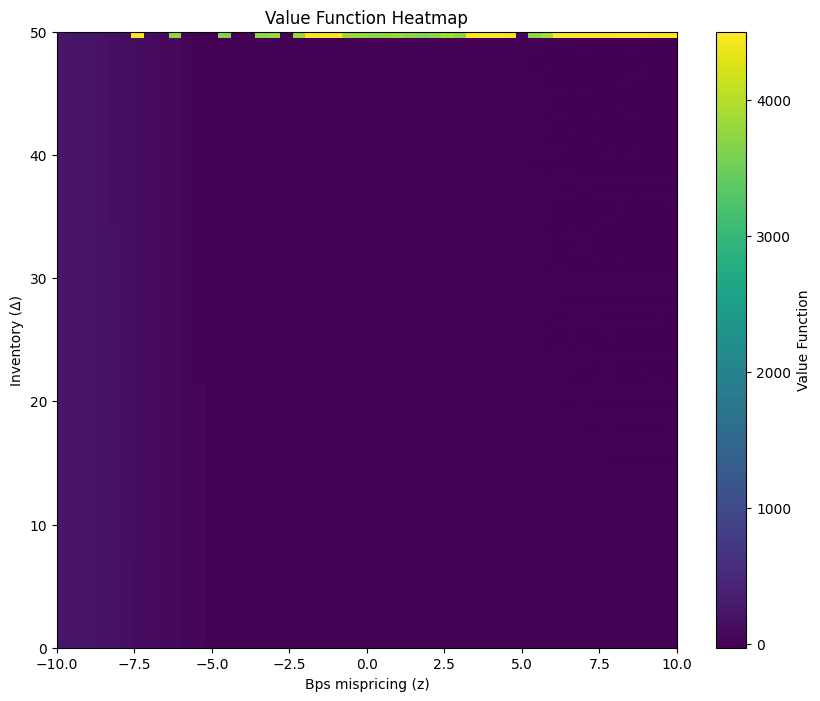

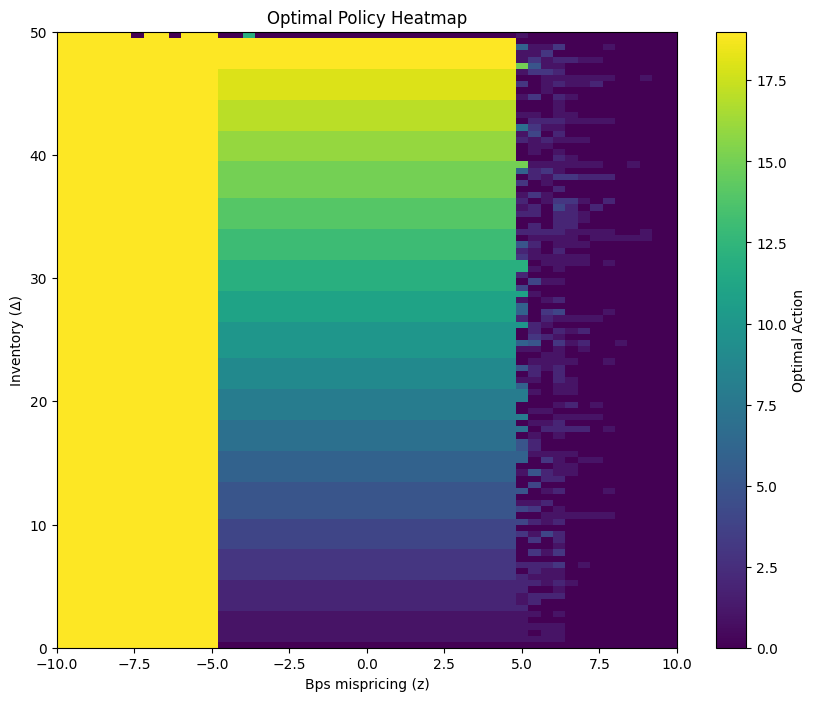

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox

class AMM_MDP:
    def __init__(self, T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho):
        self.T = T  # time steps
        self.Delta_bar = Delta_bar  # initial inventory
        self.z0 = z0  # initial mispricing
        self.R0 = R0  # initial reserve of asset 0
        self.R1 = R1  # initial reserve of asset 1
        self.p0 = R1/R0  # initial price
        self.k = R1*R0  # xy=k
        self.g = g  # gas cost
        self.sigma = sigma  # volatility of mispricing
        self.mu = mu  # mean brownian motion
        self.gamma = gamma  # fee
        self.lambda_ = lambda_  # Poisson block time
        self.phi = phi  # running inventory cost
        self.dt = 1 / T
        self.rho = rho # convexity cost of underlying AMM

        # Discretize the state and action spaces
        self.Delta_space = np.linspace(0, Delta_bar, 100)
        self.z_space = np.linspace(-2 * gamma, 2 * gamma, 50)
        self.actions = np.linspace(0, Delta_bar, 20)

    def swap_jump(self, z, a):
        z_star = self.jump(z)
        return z_star + (1-self.rho)*self.R1/(self.R0 + 2*a)
        
    def execution_price_improvement(self, z, a):
        z_star = self.jump(z)
        return (z_star - self.rho * self.R1/(self.R0 + a)) * a

    def jump(self, z):
        if z > self.gamma:
            return self.gamma - z
        elif z < -self.gamma:
            return -self.gamma - z
        else:
            return 0
  
    def transition(self, Delta, z, a):
        Delta_next = Delta - a
        z = z + self.mu * self.dt + self.sigma * np.sqrt(self.dt) * np.random.randn()
        J = self.jump(z)
        z_star = z + J
        z_next = z_star + self.swap_jump(z_star, a)
        return Delta_next, z_next

    def reward(self, Delta, z, a):
        reward = self.execution_price_improvement(z, a)
        reward -= self.g * (a > 0) + self.phi * Delta
        return reward

    def terminal_reward(self, Delta, z):
        z_star = self.jump(z)
        return (-z_star + self.rho * self.R1/(self.R0 + Delta)) * Delta

    def build_mdp_matrices(self):
        n_states = len(self.Delta_space) * len(self.z_space)
        n_actions = len(self.actions)
        P = np.zeros((n_actions, n_states, n_states))
        R = np.zeros((n_states, n_actions))

        for i, Delta in enumerate(self.Delta_space):
            for j, z in enumerate(self.z_space):
                state_index = i * len(self.z_space) + j
                for k, a in enumerate(self.actions):
                    Delta_next, z_next = self.transition(Delta, z, a)
                    reward = self.reward(Delta, z, a)

                    Delta_index = np.searchsorted(self.Delta_space, Delta_next)
                    z_index = np.searchsorted(self.z_space, z_next)
                    Delta_index = min(Delta_index, len(self.Delta_space) - 1)
                    z_index = min(z_index, len(self.z_space) - 1)
                    next_state_index = Delta_index * len(self.z_space) + z_index

                    P[k, state_index, next_state_index] += 1
                    R[state_index, k] = reward

                    # Add terminal reward
                    if i == len(self.Delta_space) - 1:  # If it's the last time step
                        R[state_index, k] += self.terminal_reward(Delta_next, z_next)

        # Normalize transition probabilities
        for k in range(n_actions):
            P[k] /= P[k].sum(axis=1)[:, None]

        return P, R

    def simulate(self, policy, num_simulations=100):
        inventory_paths = []
        for _ in range(num_simulations):
            Delta = self.Delta_bar
            z = self.z0
            inventory = [Delta]
            for t in range(self.T):
                state_index = np.searchsorted(self.Delta_space, Delta) * len(self.z_space) + np.searchsorted(self.z_space, z)
                action_index = policy[state_index]
                action = self.actions[action_index]
                Delta, z = self.transition(Delta, z, action)
                inventory.append(Delta)
            inventory_paths.append(inventory)
        return np.mean(inventory_paths, axis=0)

# Parameters
T = 10
Delta_bar = 50
z0 = 0
R0 = 10000
R1 = 10000
gamma = 5  # 0.3% fee
g = 0.1
sigma = 10
mu = 0
lambda_ = 1
phi = .1  # Running inventory cost
rho = 0.01 #convexity cost

# Initialize MDP
mdp = AMM_MDP(T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho)

# Build transition and reward matrices
P, R = mdp.build_mdp_matrices()

# Solve MDP using value iteration
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.99)
vi.run()

# Visualize the value function and optimal policy for the last phi value
value_function_reshaped = np.array(vi.V).reshape((len(mdp.Delta_space), len(mdp.z_space)))
optimal_policy_reshaped = np.array(vi.policy).reshape((len(mdp.Delta_space), len(mdp.z_space)))

# Value Function Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(value_function_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)])
plt.colorbar(label='Value Function')
plt.xlabel('Bps mispricing (z)')
plt.ylabel('Inventory (Δ)')
plt.title('Value Function Heatmap')
plt.show()

# Optimal Policy Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(optimal_policy_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)])
plt.colorbar(label='Optimal Action')
plt.xlabel('Bps mispricing (z)')
plt.ylabel('Inventory (Δ)')
plt.title('Optimal Policy Heatmap')
plt.show()

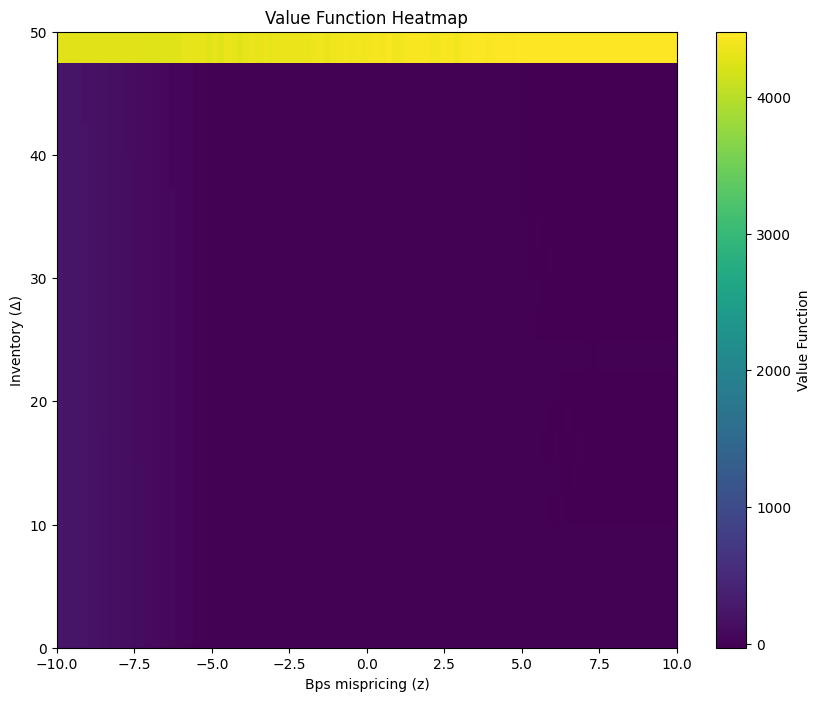

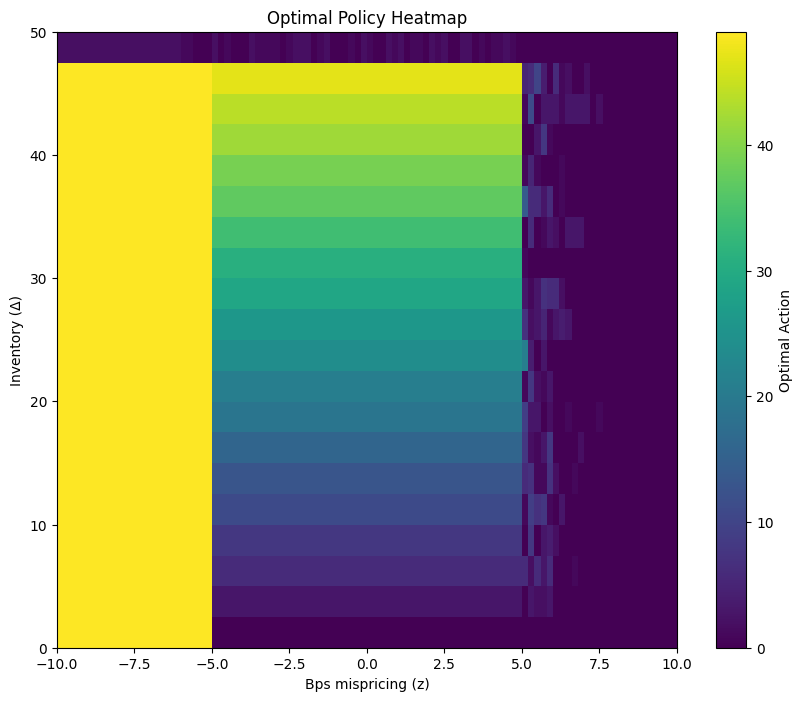

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox

class AMM_MDP:
    def __init__(self, T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho):
        self.T = T  # time steps
        self.Delta_bar = Delta_bar  # initial inventory
        self.z0 = z0  # initial mispricing
        self.R0 = R0  # initial reserve of asset 0
        self.R1 = R1  # initial reserve of asset 1
        self.p0 = R1/R0  # initial price
        self.k = R1*R0  # xy=k
        self.g = g  # gas cost
        self.sigma = sigma  # volatility of mispricing
        self.mu = mu  # mean brownian motion
        self.gamma = gamma  # fee
        self.lambda_ = lambda_  # Poisson block time
        self.phi = phi  # running inventory cost
        self.dt = 1 / T
        self.rho = rho # convexity cost of underlying AMM

        # Discretize the state and action spaces
        self.Delta_space = np.linspace(0, Delta_bar, 20)
        self.z_space = np.linspace(-2 * gamma, 2 * gamma, 100)
        self.actions = np.linspace(0, Delta_bar, 50)

    def swap_jump(self, z, a):
        z_star = self.jump(z)
        return z_star + (1-self.rho)*self.R1/(self.R0 + 2*a)
        
    def execution_price_improvement(self, z, a):
        z_star = self.jump(z)
        return (z_star - self.rho * self.R1/(self.R0 + a)) * a

    def jump(self, z):
        if z > self.gamma:
            return self.gamma - z
        elif z < -self.gamma:
            return -self.gamma - z
        else:
            return 0
  
    def transition(self, Delta, z, a):
        Delta_next = Delta - a
        z = z + self.mu * self.dt + self.sigma * np.sqrt(self.dt) * np.random.randn()
        J = self.jump(z)
        z_star = z + J
        z_next = z_star + self.swap_jump(z_star, a)
        return Delta_next, z_next

    def reward(self, Delta, z, a):
        reward = self.execution_price_improvement(z, a)
        reward -= self.g * (a > 0) + self.phi * Delta
        return reward

    def terminal_reward(self, Delta, z):
        z_star = self.jump(z)
        return (-z_star + self.rho * self.R1/(self.R0 + Delta)) * Delta

    def build_mdp_matrices(self):
        n_states = len(self.Delta_space) * len(self.z_space)
        n_actions = len(self.actions)
        P = np.zeros((n_actions, n_states, n_states))
        R = np.zeros((n_states, n_actions))

        for i, Delta in enumerate(self.Delta_space):
            for j, z in enumerate(self.z_space):
                state_index = i * len(self.z_space) + j
                for k, a in enumerate(self.actions):
                    Delta_next, z_next = self.transition(Delta, z, a)
                    reward = self.reward(Delta, z, a)

                    Delta_index = np.searchsorted(self.Delta_space, Delta_next)
                    z_index = np.searchsorted(self.z_space, z_next)
                    Delta_index = min(Delta_index, len(self.Delta_space) - 1)
                    z_index = min(z_index, len(self.z_space) - 1)
                    next_state_index = Delta_index * len(self.z_space) + z_index

                    P[k, state_index, next_state_index] += 1
                    R[state_index, k] = reward

                    # Add terminal reward
                    if i == len(self.Delta_space) - 1:  # If it's the last time step
                        R[state_index, k] += self.terminal_reward(Delta_next, z_next)

        # Normalize transition probabilities
        for k in range(n_actions):
            P[k] /= P[k].sum(axis=1)[:, None]

        return P, R

    def simulate(self, policy, num_simulations=100):
        inventory_paths = []
        for _ in range(num_simulations):
            Delta = self.Delta_bar
            z = self.z0
            inventory = [Delta]
            for t in range(self.T):
                state_index = np.searchsorted(self.Delta_space, Delta) * len(self.z_space) + np.searchsorted(self.z_space, z)
                action_index = policy[state_index]
                action = self.actions[action_index]
                Delta, z = self.transition(Delta, z, action)
                inventory.append(Delta)
            inventory_paths.append(inventory)
        return np.mean(inventory_paths, axis=0)

# Parameters
T = 10
Delta_bar = 50
z0 = 0
R0 = 1000
R1 = 1000
gamma = 5  # 0.3% fee
g = 0.1
sigma = 4
mu = 0
lambda_ = 1
phi = .1  # Running inventory cost
rho = 0.1 #convexity cost

# Initialize MDP
mdp = AMM_MDP(T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho)

# Build transition and reward matrices
P, R = mdp.build_mdp_matrices()

# Solve MDP using value iteration
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.99)
vi.run()

# Visualize the value function and optimal policy for the last phi value
value_function_reshaped = np.array(vi.V).reshape((len(mdp.Delta_space), len(mdp.z_space)))
optimal_policy_reshaped = np.array(vi.policy).reshape((len(mdp.Delta_space), len(mdp.z_space)))

# Value Function Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(value_function_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)])
plt.colorbar(label='Value Function')
plt.xlabel('Bps mispricing (z)')
plt.ylabel('Inventory (Δ)')
plt.title('Value Function Heatmap')
plt.show()

# Optimal Policy Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(optimal_policy_reshaped, origin='lower', aspect='auto', 
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)])
plt.colorbar(label='Optimal Action')
plt.xlabel('Bps mispricing (z)')
plt.ylabel('Inventory (Δ)')
plt.title('Optimal Policy Heatmap')
plt.show()

Sigma: 0.00, Improvement: -1.13%
Sigma: 0.20, Improvement: -1.15%
Sigma: 0.41, Improvement: -1.06%
Sigma: 0.61, Improvement: -1.17%
Sigma: 0.82, Improvement: -1.15%
Sigma: 1.02, Improvement: -1.04%
Sigma: 1.22, Improvement: -1.05%
Sigma: 1.43, Improvement: -1.23%
Sigma: 1.63, Improvement: -1.03%
Sigma: 1.84, Improvement: -1.08%
Sigma: 2.04, Improvement: -1.16%
Sigma: 2.24, Improvement: -1.21%
Sigma: 2.45, Improvement: -1.01%
Sigma: 2.65, Improvement: -1.23%
Sigma: 2.86, Improvement: -0.68%
Sigma: 3.06, Improvement: -1.00%
Sigma: 3.27, Improvement: -0.85%
Sigma: 3.47, Improvement: -0.79%
Sigma: 3.67, Improvement: -1.36%
Sigma: 3.88, Improvement: -0.75%
Sigma: 4.08, Improvement: -0.44%
Sigma: 4.29, Improvement: -1.10%
Sigma: 4.49, Improvement: -0.02%
Sigma: 4.69, Improvement: -0.88%
Sigma: 4.90, Improvement: -1.05%
Sigma: 5.10, Improvement: -0.36%
Sigma: 5.31, Improvement: -0.64%
Sigma: 5.51, Improvement: -0.23%
Sigma: 5.71, Improvement: -0.96%
Sigma: 5.92, Improvement: 0.05%
Sigma: 6.12

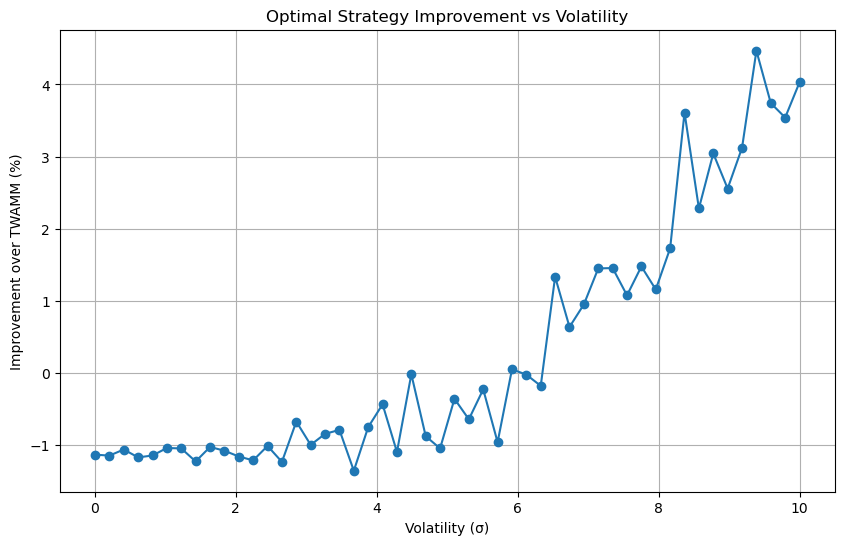

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox

class AMM_MDP:
    def __init__(self, T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho):
        self.T = T  # time steps
        self.Delta_bar = Delta_bar  # initial inventory
        self.z0 = z0  # initial mispricing
        self.R0 = R0  # initial reserve of asset 0
        self.R1 = R1  # initial reserve of asset 1
        self.p0 = R1/R0  # initial price
        self.k = R1*R0  # xy=k
        self.g = g  # gas cost
        self.sigma = sigma  # volatility of mispricing
        self.mu = mu  # mean brownian motion
        self.gamma = gamma  # fee
        self.lambda_ = lambda_  # Poisson block time
        self.phi = phi  # running inventory cost
        self.dt = 1 / T
        self.rho = rho # convexity cost of underlying AMM

        # Discretize the state and action spaces
        self.Delta_space = np.linspace(0, Delta_bar, 100)
        self.z_space = np.linspace(-2 * gamma, 2 * gamma, 50)
        self.actions = np.linspace(0, Delta_bar, 20)

    def swap_jump(self, z, a):
        z_star = self.jump(z)
        return z_star + (1-self.rho)*self.R1/(self.R0 + 2*a)
        
    def execution_price_improvement(self, z, a):
        z_star = self.jump(z)
        return (z_star - self.rho * self.R1/(self.R0 + a)) * a

    def jump(self, z):
        if z > self.gamma:
            return self.gamma - z
        elif z < -self.gamma:
            return -self.gamma - z
        else:
            return 0
  
    def transition(self, Delta, z, a):
        Delta_next = Delta - a
        z = z + self.mu * self.dt + self.sigma * np.sqrt(self.dt) * np.random.randn()
        J = self.jump(z)
        z_star = z + J
        z_next = z_star + self.swap_jump(z_star, a)
        return Delta_next, z_next

    def reward(self, Delta, z, a):
        reward = self.execution_price_improvement(z, a)
        reward -= self.g * (a > 0) + self.phi * Delta**2
        return reward

    def terminal_reward(self, Delta, z):
        z_star = self.jump(z)
        return (-z_star + self.rho * self.R1/(self.R0 + Delta)) * Delta

    def build_mdp_matrices(self):
        n_states = len(self.Delta_space) * len(self.z_space)
        n_actions = len(self.actions)
        P = np.zeros((n_actions, n_states, n_states))
        R = np.zeros((n_states, n_actions))

        for i, Delta in enumerate(self.Delta_space):
            for j, z in enumerate(self.z_space):
                state_index = i * len(self.z_space) + j
                for k, a in enumerate(self.actions):
                    Delta_next, z_next = self.transition(Delta, z, a)
                    reward = self.reward(Delta_next, z, a)

                    Delta_index = np.searchsorted(self.Delta_space, Delta_next)
                    z_index = np.searchsorted(self.z_space, z_next)
                    Delta_index = min(Delta_index, len(self.Delta_space) - 1)
                    z_index = min(z_index, len(self.z_space) - 1)
                    next_state_index = Delta_index * len(self.z_space) + z_index

                    P[k, state_index, next_state_index] += 1
                    R[state_index, k] = reward

                    # Add terminal reward
                    if i == len(self.Delta_space) - 1:  # If it's the last time step
                        R[state_index, k] += self.terminal_reward(Delta_next, z_next)

        # Normalize transition probabilities
        for k in range(n_actions):
            P[k] /= P[k].sum(axis=1)[:, None]

        return P, R

    def simulate(self, policy, num_simulations=100):
        inventory_paths = []
        for _ in range(num_simulations):
            Delta = self.Delta_bar
            z = self.z0
            inventory = [Delta]
            for t in range(self.T):
                state_index = np.searchsorted(self.Delta_space, Delta) * len(self.z_space) + np.searchsorted(self.z_space, z)
                action_index = policy[state_index]
                action = self.actions[action_index]
                Delta, z = self.transition(Delta, z, action)
                inventory.append(Delta)
            inventory_paths.append(inventory)
        return np.mean(inventory_paths, axis=0)

    def twamm_reward(self):
        total_reward = 0
        Delta = self.Delta_bar
        z = self.z0
        chunk_size = self.Delta_bar / self.T
        
        for _ in range(self.T):
            z_star = self.jump(z)
            reward = (z_star - self.rho * self.R1/(self.R0 + chunk_size)) * chunk_size
            total_reward += reward
            
            # Update z for next iteration
            z = z + self.mu * self.dt + self.sigma * np.sqrt(self.dt) * np.random.randn() + self.swap_jump(z, chunk_size)
        
        return total_reward - self.g

    def optimal_reward(self, policy):
        total_reward = 0
        Delta = self.Delta_bar
        z = self.z0
        inventory_cost = 0
        
        for _ in range(self.T):
            state_index = np.searchsorted(self.Delta_space, Delta) * len(self.z_space) + np.searchsorted(self.z_space, z)
            action_index = policy[state_index]
            action = self.actions[action_index]
            
            z_star = self.jump(z)
            reward = (z_star - self.rho * self.R1/(self.R0 + action)) * action - self.g
            total_reward += reward
            
            Delta, z = self.transition(Delta, z, action)
        return total_reward

def calculate_improvement(sigma, num_simulations=5000):
    # Parameters
    T = 25
    Delta_bar = 500
    z0 = 0
    R0 = 10000
    R1 = 10000
    gamma = 5  # 0.3% fee
    g = 15.75
    mu = 0
    lambda_ = 1
    phi = .05  # Running inventory cost
    rho = 0.01  # convexity cost

    mdp = AMM_MDP(T, Delta_bar, z0, R0, R1, g, sigma, mu, gamma, lambda_, phi, rho)
    P, R = mdp.build_mdp_matrices()
    vi = mdptoolbox.mdp.ValueIteration(P, R, 1)
    vi.run()

    optimal_rewards = []
    twamm_rewards = []

    for _ in range(num_simulations):
        optimal_rewards.append(mdp.optimal_reward(vi.policy))
        twamm_rewards.append(mdp.twamm_reward())

    avg_optimal = np.mean(optimal_rewards)
    avg_twamm = np.mean(twamm_rewards)
    improvement = (avg_optimal - avg_twamm) / np.abs(avg_twamm) * 100  # Percentage improvement

    return improvement

# Plot improvement vs volatility
sigma_values = np.linspace(0, 10, 50)
improvements = []

for sigma in sigma_values:
    imp = calculate_improvement(sigma)
    improvements.append(imp)
    print(f"Sigma: {sigma:.2f}, Improvement: {imp:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(sigma_values, improvements, marker='o')
plt.xlabel('Volatility (σ)')
plt.ylabel('Improvement over TWAMM (%)')
plt.title('Optimal Strategy Improvement vs Volatility')
plt.grid(True)
plt.show()

In [79]:
calculate_improvement(0)

53.34456240250053

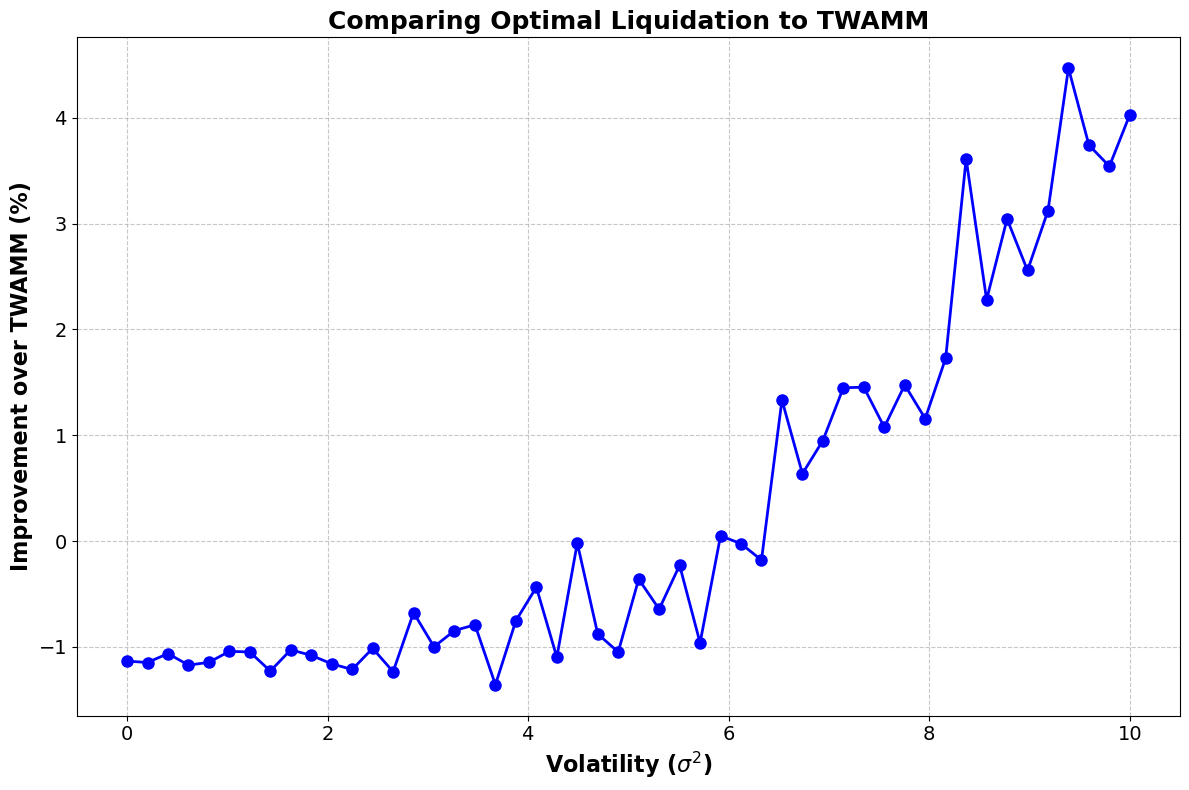

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(sigma_values, improvements, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)
plt.xlabel('Volatility ($\sigma^2$)', fontsize=16, fontweight='bold')
plt.ylabel('Improvement over TWAMM (%)', fontsize=16, fontweight='bold')
plt.title('Comparing Optimal Liquidation to TWAMM', fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)  # Light dashed grid lines
plt.xticks(fontsize=14)  # Increase x-axis tick label size
plt.yticks(fontsize=14)  # Increase y-axis tick label size
plt.tight_layout()  # Adjust layout to fit elements

# Save the figure with high DPI
plt.savefig('figures/optimal_strategy_improvement_vs_volatility.png', dpi=500, bbox_inches='tight')
plt.savefig('figures/optimal_strategy_improvement_vs_volatility.pdf', dpi=500, bbox_inches='tight')
plt.show()